## Step 3: Training on the merged dataset

**Objectives**

- 4.1. Importing the dataset
- 4.2. Creating a function to preprocess the dataset
- 4.3. Preproccessing the dataset for LSTM
- 4.4. Building the LSTM model
- 4.5. Testing the model


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### 4.1. Importing the dataset


In [6]:
#csvFilePath = 'infosys_merged.csv'
df = pd.read_csv('infosys_merged.csv')


### 4.2. Creating a function to preprocess the dataset

The `createDataset` function is designed to prepare data for training a time-series prediction model. It takes the input features (`dataset`), the target variable (`target`), and an optional parameter `lookBack`, which determines how many past time steps the model should consider. The function then iterates through the dataset, creating pairs of input sequences (`dataX`) and corresponding target values (`dataY`). For each iteration, a window of time steps equal to `lookBack` is taken from the dataset, and this window becomes a sequence in `dataX`. The target value corresponding to the last time step in the window is added to `dataY`. The function returns two arrays suitable for training a model, where each row in `dataX` represents a sequence of past observations, and the corresponding element in `dataY` is the target value to be predicted. This kind of dataset preparation is particularly useful for training models like Long Short-Term Memory (LSTM) networks, which can capture temporal dependencies in sequential data.


Absolutely! Let's walk through the first 3 iterations of the `createDataset` function with the provided information:

**Inputs:**

- `dataset`: List containing closing prices (assuming these are the values you provided):
  ```
  dataset = [633.47, 633.5, 632.5, 642.5, 650, 647.5, 650.5, 639.95, 645]
  ```
- `target`: Same list as `dataset` (assuming target values are also closing prices on the next day).
- `lookBack`: We'll use 3 (considering past 3 opening prices for prediction).

**Iteration 1 (i=0):**

- `a = dataset[0:(0 + 3), :]`: This takes the first 3 elements from `dataset`: `a = [633.47, 633.5, 632.5]`.
- `dataX.append(a)`: Adds this past data chunk to `dataX`: `dataX = [[633.47, 633.5, 632.5]]`.
- `dataY.append(target[0 + 3])`: Retrieves the target value (4th element): `dataY.append(642.5)`.

**Iteration 2 (i=1):**

- `a = dataset[1:(1 + 3), :]`: Takes elements from index 1 to 3 (exclusive): `a = [633.5, 632.5, 642.5]`.
- `dataX.append(a)`: Adds this past data chunk to `dataX`: `dataX = [[633.47, 633.5, 632.5], [633.5, 632.5, 642.5]]`.
- `dataY.append(target[1 + 3])`: Retrieves the target value (5th element): `dataY.append(650)`.

**Iteration 3 (i=2):**

- `a = dataset[2:(2 + 3), :]`: Takes elements from index 2 to 4 (exclusive): `a = [632.5, 642.5, 650]`.
- `dataX.append(a)`: Adds this past data chunk to `dataX`: `dataX = [[633.47, 633.5, 632.5], [633.5, 632.5, 642.5], [632.5, 642.5, 650]]`.
- `dataY.append(target[2 + 3])`: Retrieves the target value (6th element): `dataY.append(647.5)`.

**After 3 Iterations:**

- `dataX`: List of lists containing past data chunks:
  ```
  dataX = [[633.47, 633.5, 632.5], [633.5, 632.5, 642.5], [632.5, 642.5, 650]]
  ```
- `dataY`: Single list containing target values (closing prices on the next day) corresponding to each chunk in `dataX`:
  ```
  dataY = [642.5, 650, 647.5]
  ```

**Note:** The loop would continue for all remaining elements in `dataset` following the same pattern. However, keep in mind that since `len(dataset)` (2714) is much larger than `lookBack` (3), the loop will iterate 2714 - 3 = 2711 times to create all the data chunks and target pairs.


In [7]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], [] #datax with past values and datay with values to be predicted
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)
    
#enddef

### 4.3. Preproccessing the dataset for LSTM

This section prepares data for training a LSTM network. It first extracts the features and the target variable (closing stock prices) from a DataFrame. Then it uses Min-Max scaling to normalize these features and the target variable, ensuring they fall within the range of 0 to 1. It utilizes the `createDataset` function, section 4.2, to structure the data into sequences suitable for training the LSTM model. The sequences represent past observations, and the corresponding targets are the next time step's closing prices to predict. Finally, the dataset gets divided into training and testing sets, and their dimensions are adjusted to fit the LSTM model's input requirements. The resulting `trainX`, `testX`, `trainY`, and `testY` are now ready for training and evaluating the LSTM model's performance in predicting future stock prices based on historical patterns.


In [8]:
features = df.drop(['Date', 'Open'], axis=1).values#axis =1means col drop this will have all columns except date and Open of all rows in array
target = df['Open'].values  #all the open values in an array

scalerFeatures = MinMaxScaler(feature_range=(0, 1))# This line creates a MinMaxScaler object.
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))#target.reshape(-1, 1): This reshapes the target variable into a 2D array with one column and as many rows as 
#necessary The -1 in the reshape function indicates that the number of rows should be inferred based on the length of the target variable.
#print(target)
'''why we are using reshape(-1,1) for target is because target is a 1d array and MinMaxScaler's fit_transform expects a 2d array 
by using (-1,1)means that we want numpy to calculate the correct number of rows for a new array that has exactly one column.
 The -1 is a placeholder that means "whatever dimension is needed. it needs to be reshaped into a 2D array before being passed to fit_transform. 
 That's why target.reshape(-1, 1) is used'''
#print(featuresScaled[:5])

lookBack = 5
X, y = createDataset(featuresScaled, targetScaled, lookBack)


trainSize = int(len(X) * 0.95) # len(X)is 2710 now its 90% training and 5% testing
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))#this is reshaping the trainX,trainY from 2d to 3d array
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))
#trainX.shape[0] is the number of rows in the trainX array, lookBack is the number of columns, and trainX.shape[2] is the number of features in the dataset.
''' when you access trainX.shape[0], you're getting the first dimension of the trainX array, which is the number of rows.
 In the context of machine learning, each row typically represents a 
separate sample in your dataset, so trainX.shape[0] is the total number of samples/rows in your trainX dataset
lookback is the number of values in the stacked array trainX.shape[2] is the number of features in the dataset
'''


" when you access trainX.shape[0], you're getting the first dimension of the trainX array, which is the number of rows.\n In the context of machine learning, each row typically represents a \nseparate sample in your dataset, so trainX.shape[0] is the total number of samples/rows in your trainX dataset\nlookback is the number of values in the stacked array trainX.shape[2] is the number of features in the dataset\n"

In [9]:
X_combined = np.concatenate((trainX,testX), axis=0)
print(X_combined.shape)

(2708, 5, 9)


### 4.4. Building the LSTM model


In [26]:

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

import tensorflow as tf

# Hyperparameters

np.random.seed(21)
tf.random.set_seed(42)

batchSize = 32
epoch = 25

neurons = [100, 80, 50, 30]  # LSTM units in each layer, matching code1

# LSTM architecture
model = Sequential()

# First LSTM layer with Dropout regularisation
model.add(LSTM(units=neurons[0], return_sequences=True, input_shape=(lookBack, features.shape[1])))
model.add(Dropout(0.3))

# Second LSTM layer with Dropout regularisation
model.add(LSTM(units=neurons[1], return_sequences=True))
model.add(Dropout(0.1))

# Third LSTM layer with Dropout regularisation
model.add(LSTM(units=neurons[2], return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer with Dropout regularisation
model.add(LSTM(units=neurons[3]))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1))
model.summary()

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
from keras.callbacks import Callback


class CustomEarlyStopping(Callback):
    def __init__(self, baseline):
        super(CustomEarlyStopping, self).__init__()
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if np.less(current, self.baseline):
            self.model.stop_training = True
            print(f"Epoch {epoch+1}: early stopping as val_loss has reached below baseline")


early_stop = CustomEarlyStopping(baseline=0.00099999)
model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2, callbacks=[early_stop])
#model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)


c:\Users\tebym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 5, 100)         │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 5, 80)          │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 5, 50)          │        26,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,871 (538.56 KB)

 Trainable params: 137,871 (538.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0202 - val_loss: 0.0019
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 7/25
61/65 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.4364e-04Epoch 7: early stopping as val_loss has reached below baseline
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.3951e-04 - val_loss: 9.0114e-04


### 4.5. Testing the model

- 4.5.1. Running prediction over the training set and testing set
- 4.5.2. Calculating the score and accuracy of the model
- 4.5.3. Visualizing the data


#### 4.5.1. Running prediction over the training set and testing set


In [27]:
trainPredict = model.predict(trainX)#predicted values from your model for training data
testPredict = model.predict(testX)#predicted values from your model for testing data

trainPredictInv = scalerTarget.inverse_transform(trainPredict)#inverse transform to get the original values
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

'''after this , trainPredictInv, trainYInv, testPredictInv, and testYInv will 
contain the predictions and actual values in their original scale,'''

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


'after this , trainPredictInv, trainYInv, testPredictInv, and testYInv will \ncontain the predictions and actual values in their original scale,'

The variables `trainYInv` and `testYInv` contain the original values that your model tried to predict. These are the actual values in their original scale.

Here's a brief explanation of what each variable represents:

- `trainPredict`: The predicted values from your model for the training data, in the scaled form.
- `testPredict`: The predicted values from your model for the test data, in the scaled form.
- `trainPredictInv`: The predicted values from your model for the training data, inverse transformed to get the original values.
- `testPredictInv`: The predicted values from your model for the test data, inverse transformed to get the original values.
- `trainYInv`: The actual values for the training data in their original scale. These are the values that your model tried to predict.
- `testYInv`: The actual values for the test data in their original scale. These are the values that your model tried to predict.

So, if you want to see the original values that your model tried to predict, you should look at `trainYInv` and `testYInv`.


#### 4.5.2. Calculating the score and accuracy of the model


In [28]:
trainScore = np.sqrt(mean_squared_error(trainYInv[:, 0], trainPredictInv[:, 0]))
print(f'Training RMSE: {trainScore}')
testScore = np.sqrt(mean_squared_error(testYInv[:, 0], testPredictInv[:, 0]))
print(f'Testing RMSE: {testScore}')
trainAccuracy = 100 - (trainScore / np.mean(trainYInv) * 100)
testAccuracy = 100 - (testScore / np.mean(testYInv) * 100)
print(f'Training Accuracy: {trainAccuracy:.2f}%')
print(f'Testing Accuracy: {testAccuracy:.2f}%')

Training RMSE: 30.385336498487025
Testing RMSE: 44.32108016327312
Training Accuracy: 96.22%
Testing Accuracy: 96.87%


#### 4.5.3. Visualizing the data

- On the x-axis, the dates are displayed after every 30 days
- Test set is appended to the training set to better visualize if the prediction looks good


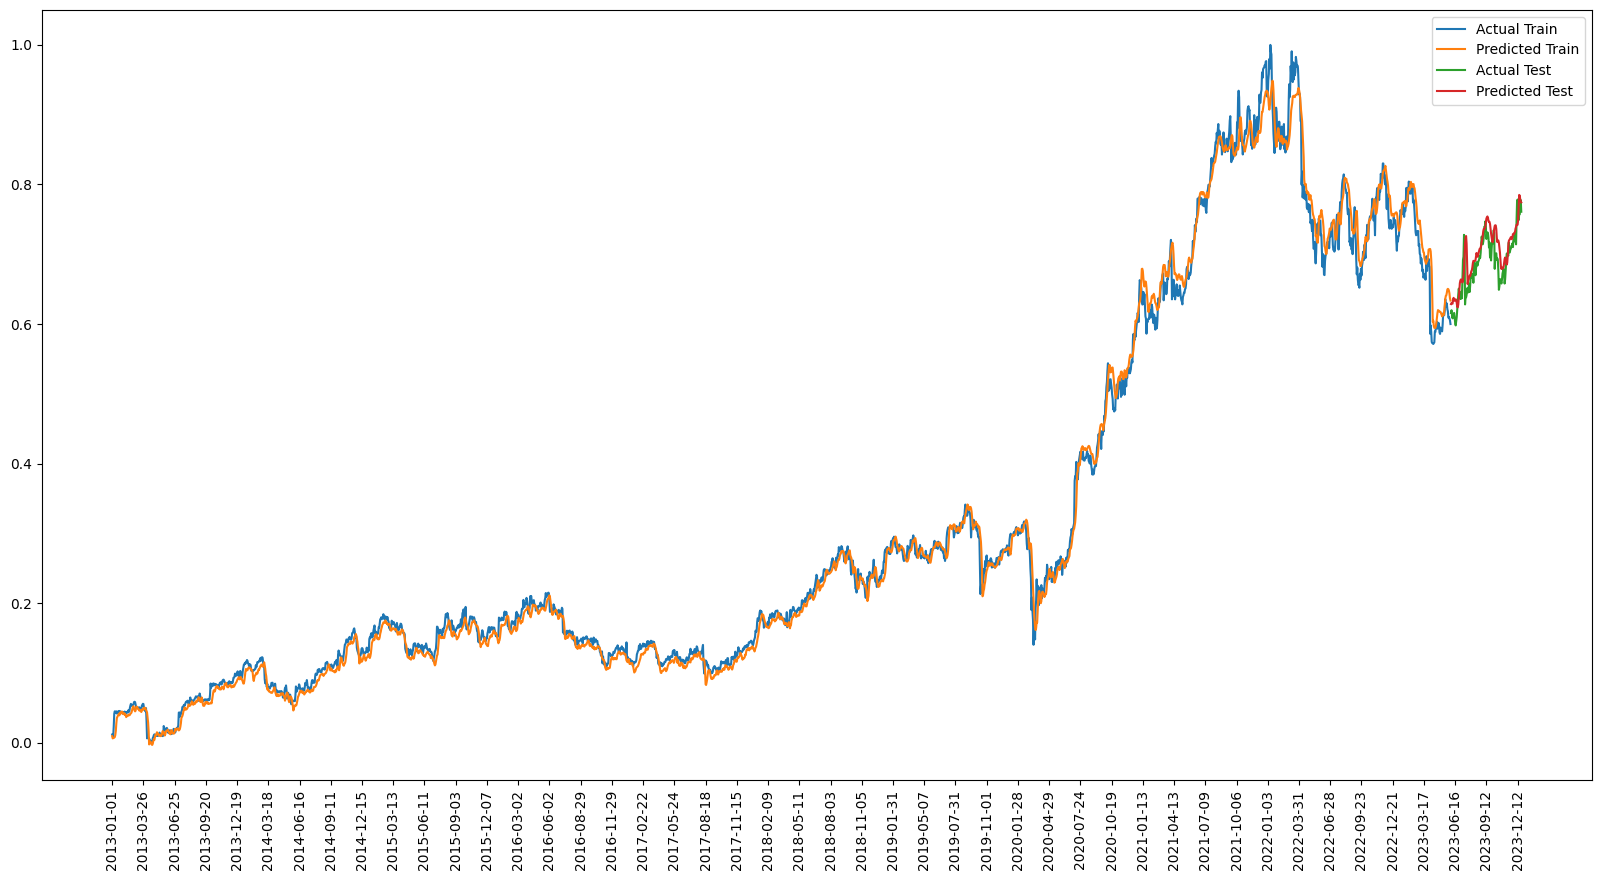

In [29]:
dates = df['Date'].values
sampleInterval = 60
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))
plt.plot(dates[:len(trainY)], trainY, label='Actual Train')
plt.plot(dates[:len(trainPredict)], trainPredict, label='Predicted Train')
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testY, label='Actual Test')
plt.plot(dates[len(trainPredict):len(trainPredict) + len(testPredict)], testPredict, label='Predicted Test')

plt.xticks(sampledDates, rotation=90)

plt.legend()
plt.show()

In [30]:
import plotly.express as px
# Filter the dates
start_date = '2023-06-13'
df_filtered = df[df['Date'] >= start_date]
dates_col = df_filtered['Date'].values

# Flatten the arrays
testY_flat = testYInv.flatten()
testPredict_flat = testPredictInv.flatten()

# Create a DataFrame that contains the necessary data
df_plot = pd.DataFrame({
    'Date': dates_col,
    'Actual Open Price': testY_flat,
    'Predicted Open Price': testPredict_flat
})

# Melt the DataFrame to have 'Actual Open Price' and 'Predicted Open Price' in the same column
df_plot_melt = df_plot.melt(id_vars='Date', value_vars=['Actual Open Price', 'Predicted Open Price'], var_name='Type', value_name='Price')

# Create the line plots
fig = px.line(df_plot_melt, x='Date', y='Price', color='Type', 
              color_discrete_map={'Actual Open Price':'green', 'Predicted Open Price':'red'})

fig.update_layout(title_text='Comparison between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=13, font_color='black', legend_title_text='Open Price')

# Show the plot
fig.show()

In [15]:
testyinvflat=testYInv.flatten()

print(len(testyinvflat))
print(len(testPredictInv))
start_date = '2023-06-13'
df_filtered = df[df['Date'] >= start_date]
dates_col = df_filtered['Date'].values
print(len(dates_col))
# Create a DataFrame with actual and predicted values
df_result = pd.DataFrame({
    'dates': dates_col,
    '  Actual_Open_price': testyinvflat,
    '   Predicted_Open_price': testPredictInv.flatten()
})
pd.set_option('display.max_rows', None)#so full table gets displayed instead of truncated
print(df_result)

136
136
136
          dates    Actual_Open_price     Predicted_Open_price
0    2023-06-13          1299.900024              1301.865234
1    2023-06-14          1306.349976              1303.488037
2    2023-06-15          1293.949951              1297.973022
3    2023-06-16          1287.000000              1297.662231
4    2023-06-19          1294.000000              1307.611694
5    2023-06-20          1294.000000              1311.887817
6    2023-06-21          1299.949951              1308.059570
7    2023-06-22          1289.400024              1304.550049
8    2023-06-23          1276.449951              1307.149536
9    2023-06-26          1270.250000              1310.326416
10   2023-06-27          1280.000000              1310.974976
11   2023-06-28          1290.000000              1305.119507
12   2023-06-30          1308.199951              1294.105713
13   2023-07-03          1330.000000              1288.662354
14   2023-07-04          1344.300049              1296.109